 Ich loese die Gleichung (9) mit folgenden Methoden:
1. CG Verfahren
2. MINRES Verfahren
3. Cholesky Zerlegung
4. Eigenwertzerlegung von Matrix K
5. Signulaerwertzerlegung von Matrix X
6. Signulaerwertzerlegung von Matrix X (Arnoldi iteration)

Dabei messe ich die Zeit fuer verschiedene Teile des Verfahrens
- Einlesen von Daten
- Ausmultiplizieren der matrix K
- Fuer CG/MINRES: Loesung gesammt
- Fuer Cholesky, Eigenwertzerleung und Singulaerwertzerlegung:
Zerlegung, Ruecksubstitution

Ich vergleiche die Zeiten und Ergebnisse fuer ein fixes \lambda.


In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import scipy.linalg
from scipy.sparse.linalg import cg, minres
import pandas as pd

from matplotlib import pylab
import seaborn as sbs
sbs.set_context("talk")

In [20]:
filename_data = "data/GenoFlintSYNrep2.csv"
filename_target = "data/PhenoFlintSYNrep2.csv"
lambda_ = 1e-3

In [21]:
data_df = pd.DataFrame.from_csv(filename_data)
data = data_df.as_matrix()
X = data

targets_df = pd.DataFrame.from_csv(filename_target)
targets = targets_df.as_matrix()
y = targets[:,2]

In [22]:
# compute K
%time K = X.dot(X.T)

CPU times: user 2min 33s, sys: 80 ms, total: 2min 33s
Wall time: 2min 33s


In [62]:
K_sparse = sp.sparse.csc_matrix(K)
X_sparse = sp.sparse.csr_matrix(X)

print "X: portion of nonzeros %f"%(float(X_sparse.nnz)/np.product(X_sparse.shape))
print "K: portion of nonzeros %f"%(float(K_sparse.nnz)/np.product(K_sparse.shape))

X: portion of nonzeros 0.151842
K: portion of nonzeros 1.000000


In [23]:
A = K + lambda_ * np.eye(K.shape[0])

In [16]:
# solve system using CG 
%time res_cg = cg(A, y, tol=1e-8)

CPU times: user 53.3 ms, sys: 153 ms, total: 207 ms
Wall time: 94.7 ms


In [17]:
# solve system using minres
%time res_minres = minres(A, y, tol=1e-8)

CPU times: user 70 ms, sys: 193 ms, total: 263 ms
Wall time: 110 ms


In [19]:
# perform Cholesky factorization
%time L, is_lower = sp.linalg.cho_factor(A)

CPU times: user 20 ms, sys: 6.67 ms, total: 26.7 ms
Wall time: 19 ms


In [20]:
# perform Cholesky backsubstitution
%time x_cholesky = sp.linalg.cho_solve((L, is_lower), y)

CPU times: user 6.67 ms, sys: 0 ns, total: 6.67 ms
Wall time: 7.35 ms


In [24]:
# eigenvalue decomposition of the matrix K
%time W,VR = sp.linalg.eig(A)

CPU times: user 493 ms, sys: 553 ms, total: 1.05 s
Wall time: 305 ms


In [25]:
# eigenvalues backsubstitution
%time x_ev = VR.dot(VR.T.dot(y)*(1./W.real))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 586 µs


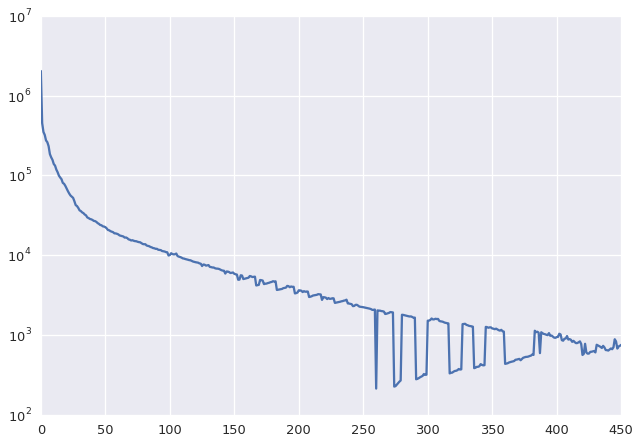

In [26]:
pylab.plot(W.real, '-', label=r"Eigenvalues of $K$")
pylab.yscale("log")

In [5]:
# singular values of X
%time U, S, V = sp.linalg.svd(X, full_matrices=False)

CPU times: user 20 s, sys: 2.63 s, total: 22.6 s
Wall time: 5.81 s


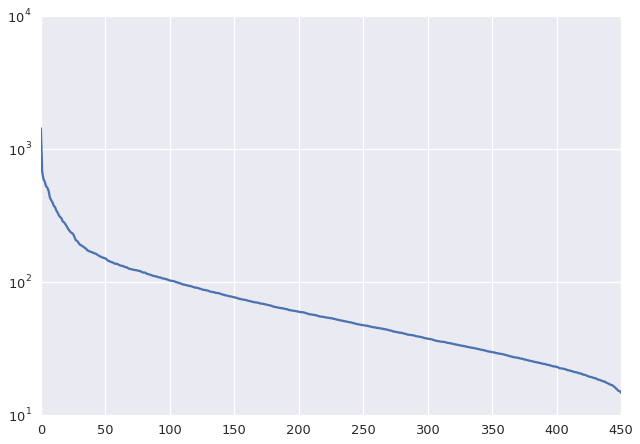

In [7]:
pylab.plot(S, '-', label=r"Singular values of $X$")
pylab.yscale('log')

In [32]:
## backsustitution of SVD
%time x_svd = U.dot(U.T.dot(y)*1./(S**2+lambda_))

CPU times: user 0 ns, sys: 6.67 ms, total: 6.67 ms
Wall time: 3.01 ms


# Timing results:

* Create matrix K explicitly: **2 minutes 33 seconds**
    * CG: 94ms
    * MINRES: 110ms
    * Cholesky: 19ms + 7.5 ms = 26.5 ms
    * Eigenvalues: 305ms + 0.5ms = 305.5ms
* Using SVD directly on the matrix X: 5.81 s + 3 ms = **6 s** (who really cares, it's not 2.5 minutes!!!)

All timing results are performed on a skylake i5 processors with 2 real cores (4 hyperthreaded cores) with multithreading turned in.

# Verification

a simple plot to verify that all results are basically the same

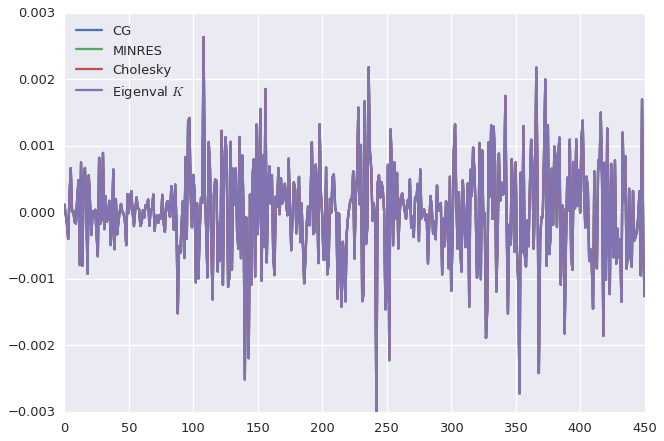

In [46]:
pylab.plot(res_cg[0], '-', label='CG')
pylab.plot(res_minres[0], '-', label='MINRES')
pylab.plot(x_cholesky, '-', label='Cholesky')
pylab.plot(x_ev, '-', label=r'Eigenval $K$')
pylab.legend(loc='best')